# Interpretation of Isolation Forest Anomaly with SHAP Explainer

## Preprocessing

### Install Libraries

In [36]:
%pip install shap
import numpy as np 
import pandas as pd
import shap
from sklearn.ensemble import IsolationForest

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load training dataset

In [37]:
df_energy = pd.read_csv("/Users/qingshuzhao/Documents/ML_PPI_project/training_dataset/Rueben_504_resolution_3.csv")
#df_energy.head

In [38]:
missing_rows = df_energy[df_energy.isna().any(axis=1)]
print(missing_rows)

df_energy = df_energy.dropna().reset_index(drop=True)

    total_score        Sc  Sc_int_area  complex_normalized    dG_cross  \
14  -644.022344  0.735974  2174.510254           -2.898735 -135.527451   

    dG_cross/dSASAx100  dG_separated  dG_separated/dSASAx100  dSASA_hphobic  \
14           -3.935843   -125.325432               -3.639567    2111.208008   

     dSASA_int  ...  rama_prepro       ref  sc_value  side1_normalized  \
14  3443.41626  ...    10.598049  54.95231  0.726296         -3.755514   

    side1_score  side2_normalized  side2_score  pdb_id  resolution  kd_molar  
14  -304.196594         -2.385358   -57.248596    6gvk        1.55  0.000002  

[1 rows x 44 columns]


In [39]:
# Add experimental binding energy by calculating Delta G = RT \ln(K_d)
df_energy['dG_exp'] = (1.98722*298.15*np.log(df_energy['kd_molar'])/1000)
print(df_energy['dG_exp'])

#Use .pop intead of .drop, so we can store the value and return it after model training
df_energy.drop(columns=['resolution', 'kd_molar'], axis=1, inplace=True)
pdb_id = df_energy.pop('pdb_id')

0      -9.461867
1      -5.349008
2     -10.420573
3      -9.667385
4      -8.222207
         ...    
498    -7.642654
499    -6.764819
500    -9.009287
501   -10.371170
502    -6.440997
Name: dG_exp, Length: 503, dtype: float64


In [40]:
X = df_energy.drop(columns=['dG_exp'])
y = df_energy['dG_exp']

### iForest

In [41]:
iforest=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.1),random_state=42)
iforest.fit(X)

y_pred = iforest.predict(X)
df_energy['anomaly_label']=y_pred

df_energy[df_energy.anomaly_label==-1].head()


,total_score,Sc,Sc_int_area,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,...,pro_close,rama_prepro,ref,sc_value,side1_normalized,side1_score,side2_normalized,side2_score,dG_exp,anomaly_label
36,-1934.376519,0.671122,813.674988,-3.194402,-46.172531,-3.178554,-42.230953,-2.907212,962.639404,1452.627197,...,5.969998,-0.624134,181.38957,0.687711,-1.908263,-68.697479,-3.651599,-65.728775,-9.984674,-1
60,-527.039529,0.818244,1545.476746,-3.026838,-104.037376,-4.201544,-88.035759,-3.555320,1725.254395,2476.169922,...,1.781685,-12.194212,42.86664,0.814751,-2.664648,-58.622265,-3.976865,-278.380524,-8.372010,-1
166,-1444.056810,0.724517,1036.076904,-2.992695,0.000000,0.000000,-95.089302,-5.253012,987.196228,1810.186157,...,5.533901,49.693262,180.90933,0.697715,-4.375517,-157.518600,-4.070958,-130.270645,-8.215938,-1
177,-448.502509,0.808293,487.038590,-2.299866,-42.408878,-4.990850,-40.400944,-4.754548,546.253845,849.732666,...,4.622043,46.946819,67.37425,0.811216,-3.538832,-84.931976,-3.586427,-46.623558,-7.783819,-1
179,-1460.628764,0.769508,2526.363892,-2.979568,-153.110336,-3.683258,-140.169449,-3.371949,2502.440918,4156.926270,...,8.281304,-27.222200,142.44570,0.782172,-3.032130,-203.152679,-3.322220,-279.066467,-8.185547,-1


### Explainer

In [42]:
explainer = shap.Explainer(iforest.predict, X)
shap_values = explainer(X)

PermutationExplainer explainer: 504it [00:40,  9.28it/s]                         


In [43]:
shap.initjs()

## Explain Single PDB

### Force Plot

In [44]:
shap.plots.force(shap_values[36])

There are three important aspects in this plot:

1. The predicted value f(x) is -1, meaning that we have an anomaly. In the case it’s normal, the output value should be equal to 1.

2. The base value, which is the average value of the target variable across all the rows of the dataset, is 0.74. You can see how the feature values increase or decrease the prediction. The double arrow indicates the impact of each feature with respect to the baseline of 0.7.

3. The features coloured in red show how they contribute to increasing the value of the prediction. The blue colour indicates how the features contribute to decreasing the prediction. In this case, the features coloured in blue are determinants to find the anomalous item, while the contribution of the red coloured variable are not enough to classify that observation as normal. The length of each arrow represents the impact of that feature on the prediction.

In [45]:
df_energy.loc[36]

total_score              -1934.376519
Sc                           0.671122
Sc_int_area                813.674988
complex_normalized          -3.194402
dG_cross                   -46.172531
dG_cross/dSASAx100          -3.178554
dG_separated               -42.230953
dG_separated/dSASAx100      -2.907212
dSASA_hphobic              962.639404
dSASA_int                 1452.627197
dSASA_polar                489.987732
ddg                        -38.660843
delta_unsatHbonds            3.000000
dslf_fa13                    0.000000
fa_atr                   -3828.940854
fa_dun                     769.007930
fa_elec                  -1076.997916
fa_intra_rep                 6.138700
fa_intra_sol_xover4        128.092877
fa_rep                     381.708603
fa_sol                    2289.477285
hbond_E_fraction             0.260553
hbond_bb_sc               -156.469833
hbond_lr_bb               -103.513919
hbond_sc                  -124.739657
hbond_sr_bb               -224.377661
hbonds_int  

### Example of a PDB classified as normal

In [46]:
shap.plots.force(shap_values[0])

## Waterfall Plot

### Anomalous PDB

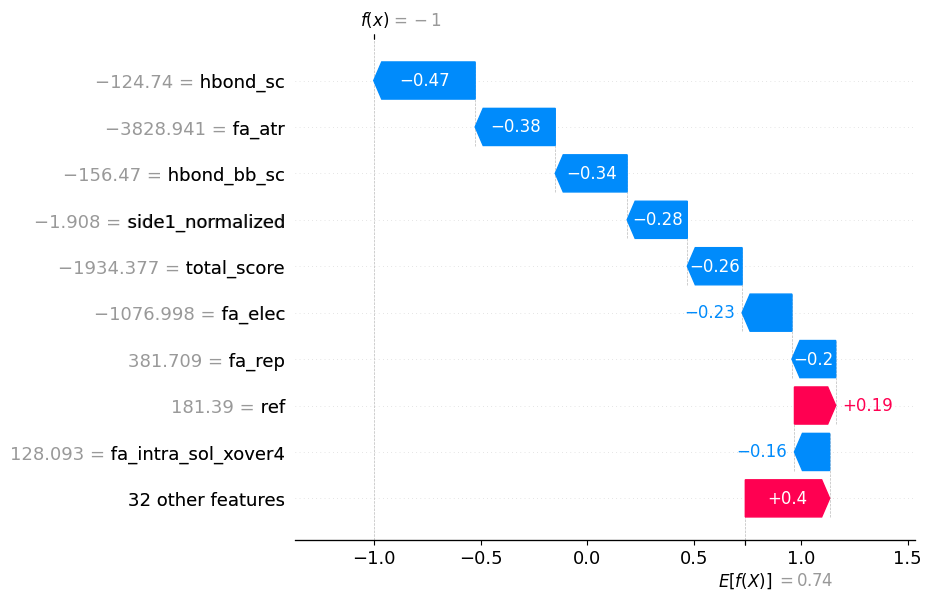

In [47]:
shap.plots.waterfall(shap_values[36])

Differently from the force plot, the waterfall provides a more elegant chart to visualize how the predicted output was obtained, given the contribution of each feature. It’s more evident how the positive (marked in red) and the negative (marked in blue) contribution of each variable moves the base value at the bottom to the model output at the top.



### Normal PDB

Below is what a normal PDB's waterfall plot looks like:

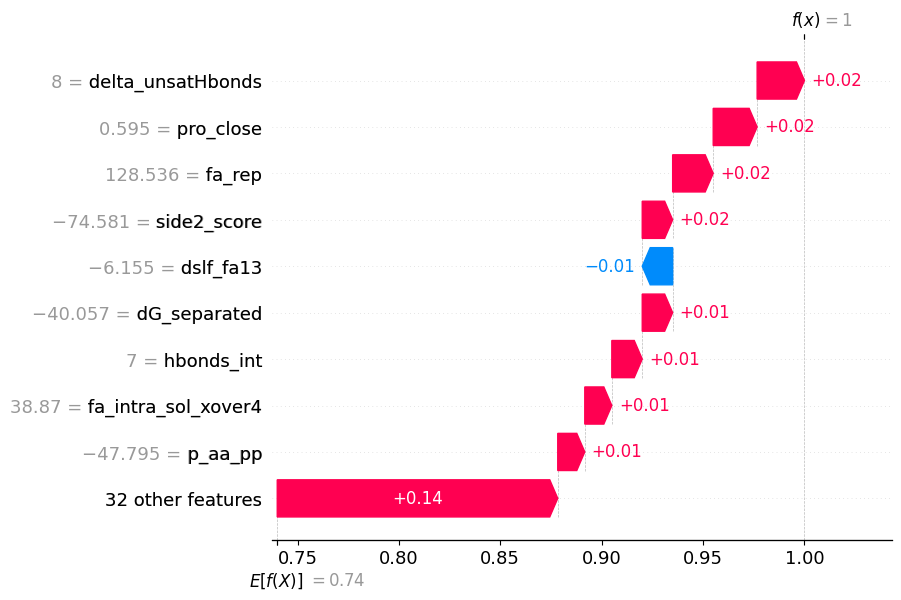

In [48]:
shap.plots.waterfall(shap_values[0])

You can see how the prediction changes when side1_score increase. Lower values of side1_score imply that we have a higher risk to have anomalous items. At the bottom, there’s a histogram showing the distribution of side1_score. Most of the data points seem to be concentrated around -150 to -100.

##  Global interpretability

### Beeswarm Plot

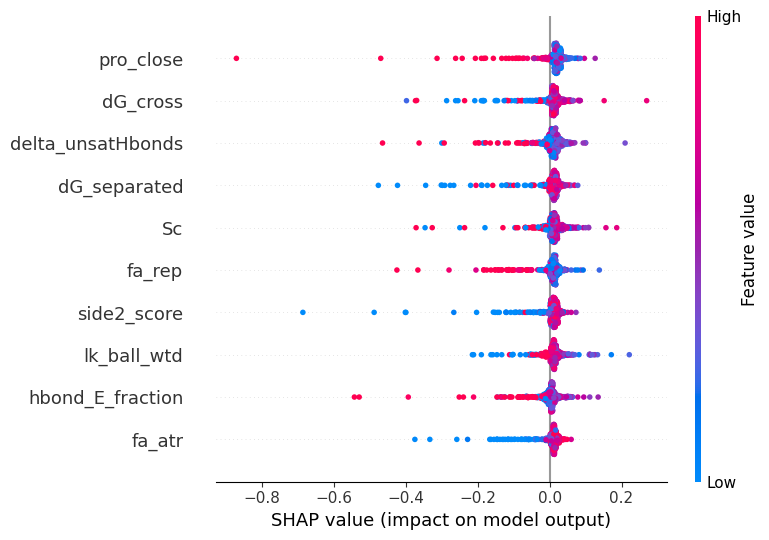

In [57]:
summary_plot=shap.summary_plot(shap_values, X, max_display=10)

1. The features are ordered based on the sum of absolute Shapley values per feature across the data. Then, the top features contribute more to the model output since they have the largest absolute values.

2. The different colours indicate the values of the features in the dataset. For example, if you look at fa_intra_rep (Intra-residue repulsive component), it’s clear that high values of this feature imply that we have an anomalous item, while lower values bring to a normal item.

### Bar plot

In global feature importance plot, the features are sorted by decreasing global importance. The global importance of each feature is calculated as the mean absolute value of that feature overall given rows of the dataset. See the plot below:

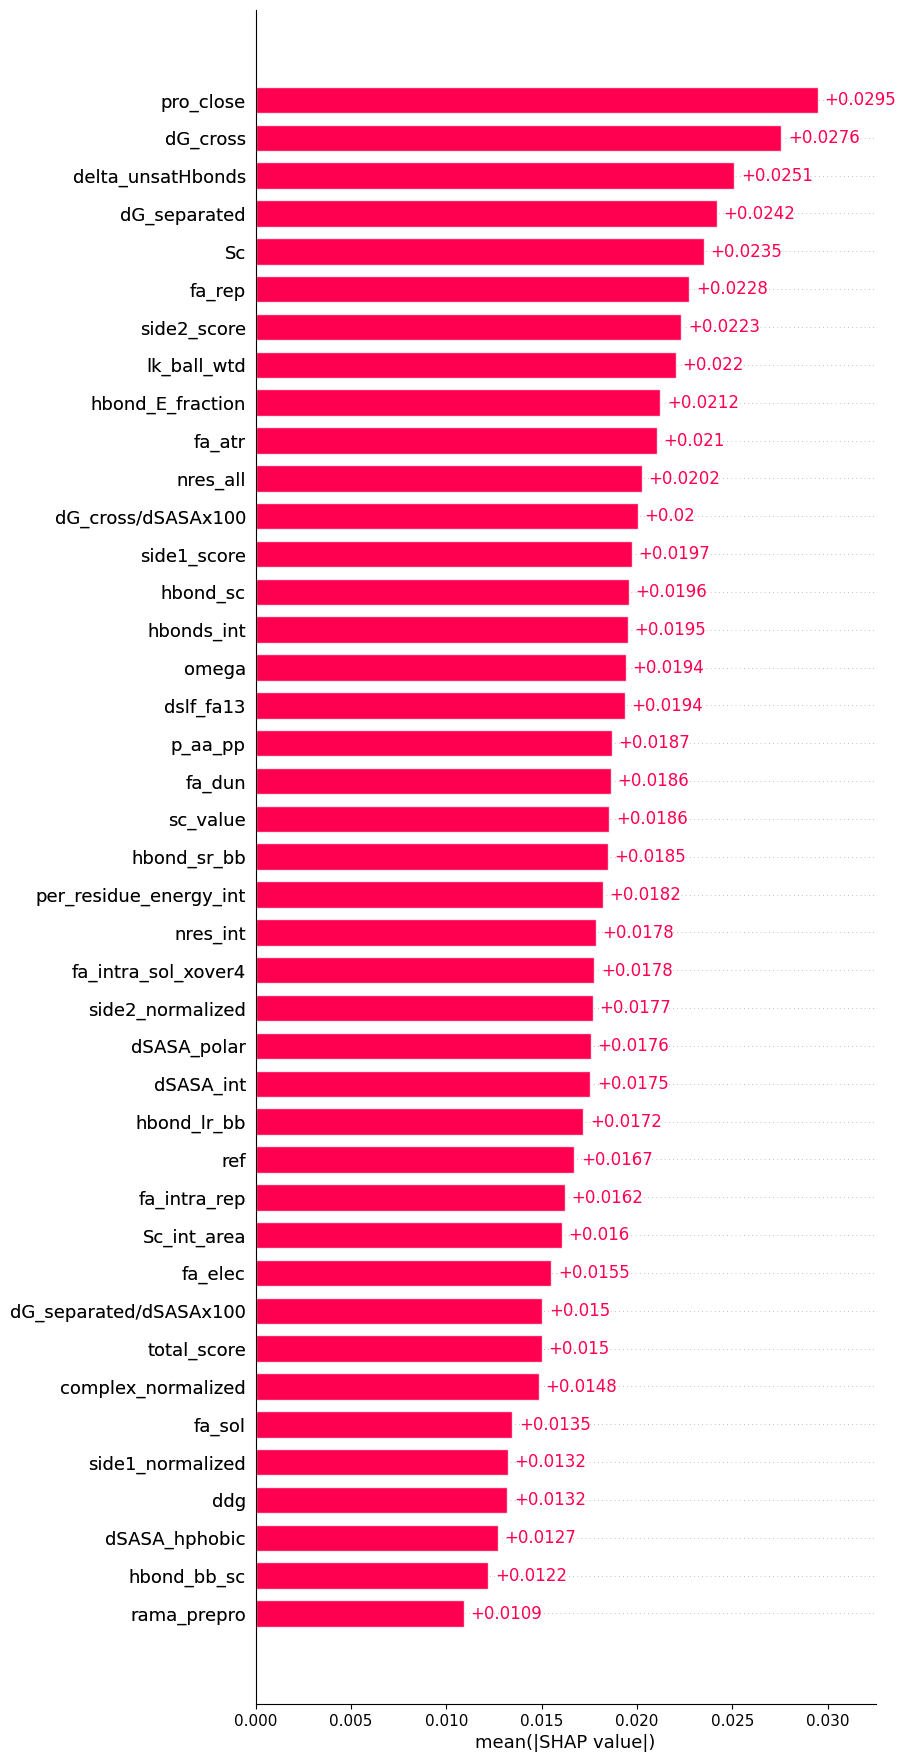

In [50]:
shap.plots.bar(shap_values,max_display=42)

## **Analysis of top three features contribute to anomalies**
Need to combine matplotlib to annotate data point with PDB names. Refer to https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html#Customizing-the-figure-properties

In [51]:
import matplotlib.pyplot as plt

### pro_close
proline ring closure. High value of pro_close indicates proline ring is not closed properly

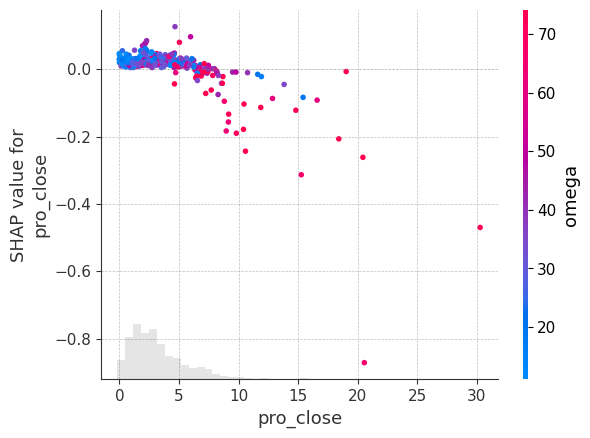

In [52]:
ax = plt.axes()
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

shap.plots.scatter(shap_values[:,'pro_close'], color=shap_values, ax=ax)

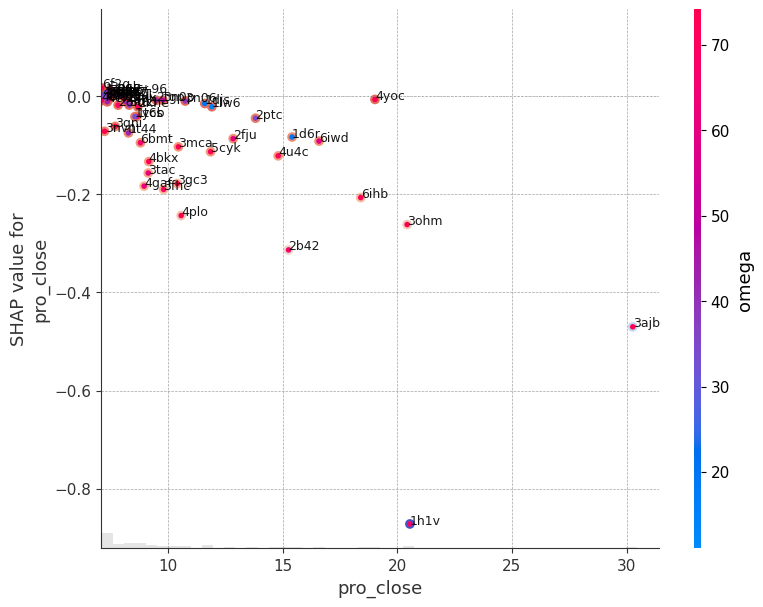

In [ ]:
# Convert relevant columns to numpy arrays
x = df_energy['pro_close']  
y = shap_values[:,'pro_close'].values 
description = pdb_id.to_numpy()

#ax = plt.axes()
fig, ax = plt.subplots(figsize=(9, 7))
sc = ax.scatter(x, y, c=y, cmap='coolwarm', alpha=0.9)
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.7)

# Annotate each data point with its corresponding description (PDB ID)
for i in range(len(x)):
    ax.annotate(description[i], (x[i], y[i]), fontsize=9, alpha=0.9)

value = shap_values[:, 'pro_close']
scatter = shap.plots.scatter(value, color=shap_values, xmin=value.percentile(90), ax=ax)

# Add labels, title, etc.
ax.set_xlabel('pro_close')
ax.set_ylabel('SHAP value for pro_close')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [20]:
pro_close_anomaly_pdb = description[shap_values[:,'pro_close'].values < -0.1].tolist()

print("PDB IDs where SHAP values for 'pro_close' are less than -0.1:")
for pdb_id in pro_close_anomaly_pdb:
    print(pdb_id)

PDB IDs where SHAP values for 'pro_close' are less than -0.1:
1t44
4gaf
2fju
3gc3
3tac
4u4c
6bmt
2b42
3ajb
3mca
3fhc
6ihb
4plo
4yoc
1h1v


In [21]:
print(pro_close_anomaly_pdb)

['1t44', '4gaf', '2fju', '3gc3', '3tac', '4u4c', '6bmt', '2b42', '3ajb', '3mca', '3fhc', '6ihb', '4plo', '4yoc', '1h1v']


### dG_cross
Binding energy of the interface calculated with cross-interface energy terms, rather than by separating the interface. Inaccurate sometimes because of environmental dependencies in some energy terms, including hbond energy and solvation.

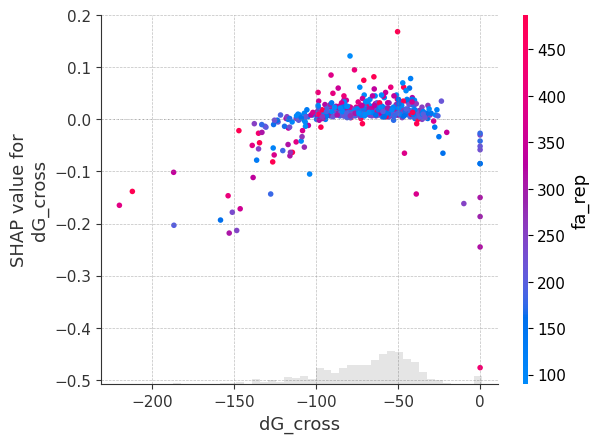

In [22]:
ax = plt.axes()
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

shap.plots.scatter(shap_values[:,'dG_cross'], color=shap_values, ax=ax)

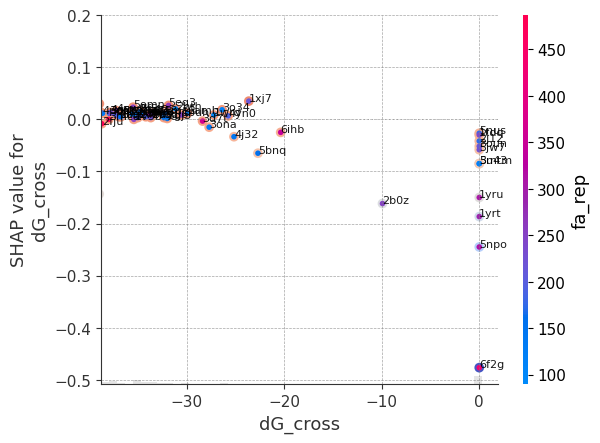

In [23]:
x = df_energy['dG_cross'] 
y = shap_values[:,'dG_cross'].values  

fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(x, y, c=y, cmap='coolwarm', alpha=0.9)
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.7)

for i in range(len(x)):
    ax.annotate(description[i], (x[i], y[i]), fontsize=8, alpha=0.9)

value = shap_values[:, 'dG_cross']
scatter = shap.plots.scatter(value, color=shap_values, xmin=value.percentile(90), ax=ax)
#scatter = shap.plots.scatter(value, color=shap_values, ymax=shap_values[:,'dG_cross'], ax=ax)

ax.set_xlabel('dG_cross')
ax.set_ylabel('SHAP value for dG_cross')
plt.show()

In [24]:
dG_cross_anomaly_pdb = description[shap_values[:,'dG_cross'].values < -0.1].tolist()

print("PDB IDs where SHAP values for 'dG_cross' are less than -0.1:")
for pdb_id in dG_cross_anomaly_pdb:
    print(pdb_id)

PDB IDs where SHAP values for 'dG_cross' are less than -0.1:
5wrv
2b7c
5npo
6pnq
1t44
3aon
1v18
1yrt
5un7
2c1m
4zrj
4ct0
5dob
1yru
2b0z
2oza
4plo
6f2g
4bkx


In [25]:
print(dG_cross_anomaly_pdb)

['5wrv', '2b7c', '5npo', '6pnq', '1t44', '3aon', '1v18', '1yrt', '5un7', '2c1m', '4zrj', '4ct0', '5dob', '1yru', '2b0z', '2oza', '4plo', '6f2g', '4bkx']


### delta_unsatHbonds
The number of buried, unsatisfied hydrogen bonds at the interface

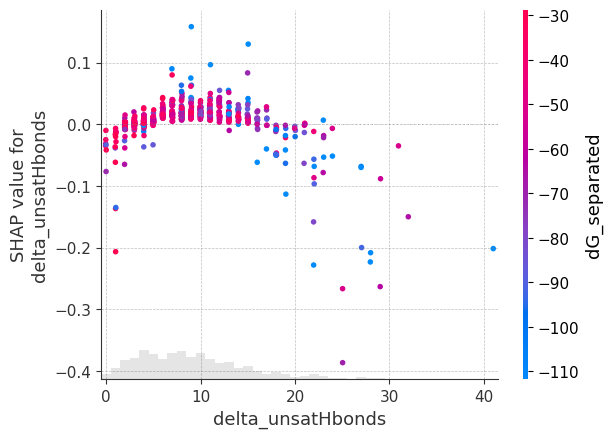

In [26]:
ax = plt.axes()
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

shap.plots.scatter(shap_values[:,'delta_unsatHbonds'], color=shap_values, ax=ax)

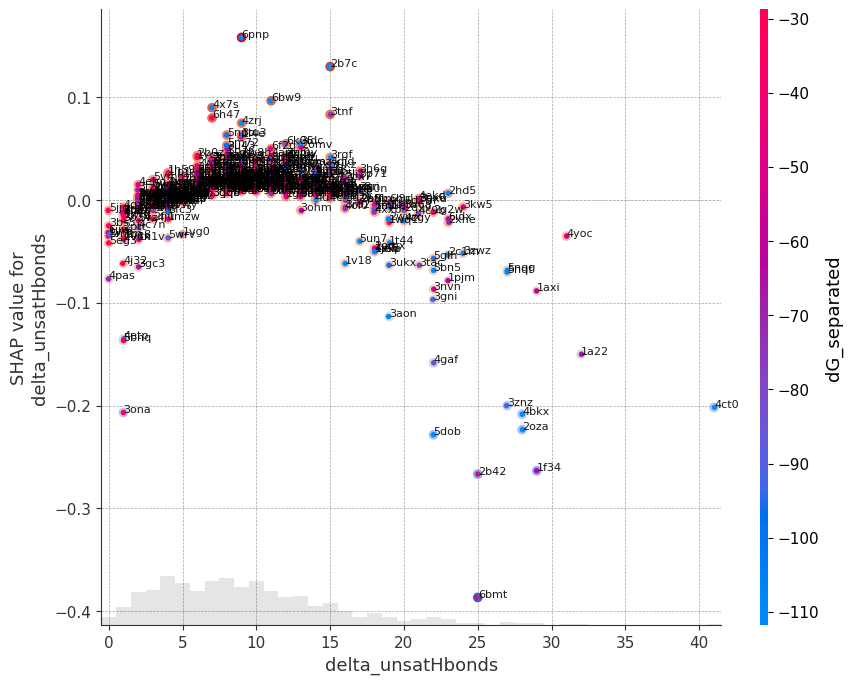

In [27]:
x = df_energy['delta_unsatHbonds'] 
y = shap_values[:,'delta_unsatHbonds'].values  

fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(x, y, c=y, cmap='coolwarm', alpha=0.9)
ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.7)

for i in range(len(x)):
    ax.annotate(description[i], (x[i], y[i]), fontsize=8, alpha=0.9)

value = shap_values[:, 'delta_unsatHbonds']
scatter = shap.plots.scatter(value, color=shap_values, xmax=value.percentile(8), ax=ax)

ax.set_xlabel('delta_unsatHbonds')
ax.set_ylabel('SHAP value for delta_unsatHbonds')
plt.show()

In [28]:
delta_unsatHbonds_anomaly_pdb = description[shap_values[:,'delta_unsatHbonds'].values < -0.1].tolist()

print("PDB IDs where SHAP values for 'delta_unsatHbonds' are less than -0.1:")
for pdb_id in delta_unsatHbonds_anomaly_pdb:
    print(pdb_id)

PDB IDs where SHAP values for 'delta_unsatHbonds' are less than -0.1:
3znz
3aon
4gaf
4etp
6bmt
1f34
4ct0
5dob
2b42
1a22
3ona
2oza
5bnq
4bkx


In [29]:
print(delta_unsatHbonds_anomaly_pdb)

['3znz', '3aon', '4gaf', '4etp', '6bmt', '1f34', '4ct0', '5dob', '2b42', '1a22', '3ona', '2oza', '5bnq', '4bkx']


## Refining PDB in training dataset

In [30]:
print(pro_close_anomaly_pdb)
print(dG_cross_anomaly_pdb)
print(delta_unsatHbonds_anomaly_pdb)


['1t44', '4gaf', '2fju', '3gc3', '3tac', '4u4c', '6bmt', '2b42', '3ajb', '3mca', '3fhc', '6ihb', '4plo', '4yoc', '1h1v']
['5wrv', '2b7c', '5npo', '6pnq', '1t44', '3aon', '1v18', '1yrt', '5un7', '2c1m', '4zrj', '4ct0', '5dob', '1yru', '2b0z', '2oza', '4plo', '6f2g', '4bkx']
['3znz', '3aon', '4gaf', '4etp', '6bmt', '1f34', '4ct0', '5dob', '2b42', '1a22', '3ona', '2oza', '5bnq', '4bkx']


In [31]:
from collections import Counter

# Combine all the PDB IDs into a single list
all_pdb_ids = pro_close_anomaly_pdb + dG_cross_anomaly_pdb + delta_unsatHbonds_anomaly_pdb

# Count occurrences of each PDB ID
pdb_count = Counter(all_pdb_ids)

# Sort the PDB IDs by their count in descending order (rank)
ranked_pdb_ids = sorted(pdb_count.items(), key=lambda item: item[1], reverse=True)

# Print the ranked PDB IDs with their count
print("Ranked PDB IDs by frequency of appearance:")
for rank, (pdb_id, count) in enumerate(ranked_pdb_ids, 1):
    print(f"{rank}. {pdb_id}: {count} times")

Ranked PDB IDs by frequency of appearance:
1. 1t44: 2 times
2. 4gaf: 2 times
3. 6bmt: 2 times
4. 2b42: 2 times
5. 4plo: 2 times
6. 3aon: 2 times
7. 4ct0: 2 times
8. 5dob: 2 times
9. 2oza: 2 times
10. 4bkx: 2 times
11. 2fju: 1 times
12. 3gc3: 1 times
13. 3tac: 1 times
14. 4u4c: 1 times
15. 3ajb: 1 times
16. 3mca: 1 times
17. 3fhc: 1 times
18. 6ihb: 1 times
19. 4yoc: 1 times
20. 1h1v: 1 times
21. 5wrv: 1 times
22. 2b7c: 1 times
23. 5npo: 1 times
24. 6pnq: 1 times
25. 1v18: 1 times
26. 1yrt: 1 times
27. 5un7: 1 times
28. 2c1m: 1 times
29. 4zrj: 1 times
30. 1yru: 1 times
31. 2b0z: 1 times
32. 6f2g: 1 times
33. 3znz: 1 times
34. 4etp: 1 times
35. 1f34: 1 times
36. 1a22: 1 times
37. 3ona: 1 times
38. 5bnq: 1 times


In [32]:
all_pdb_ids_no_duplicate= list(set(all_pdb_ids))
print(all_pdb_ids_no_duplicate)
type(all_pdb_ids_no_duplicate)

['4yoc', '2oza', '5un7', '2b0z', '6bmt', '3tac', '4etp', '5npo', '6ihb', '2b42', '2c1m', '6f2g', '1yrt', '1t44', '1v18', '4bkx', '3mca', '4zrj', '1yru', '5wrv', '3znz', '5bnq', '2b7c', '4u4c', '3ona', '5dob', '4gaf', '1h1v', '4ct0', '4plo', '1f34', '3fhc', '6pnq', '2fju', '3aon', '1a22', '3ajb', '3gc3']


list

In [33]:
# Assuming all_pdb_ids_no_duplicate is a list of PDB IDs
output_file = '/Users/qingshuzhao/Documents/ML_PPI_project/Paper/SI/all_pdb_ids_no_duplicate.csv'

# Convert the list to a DataFrame with a column named 'anomaly_id'
df_anomaly_pdb = pd.DataFrame(all_pdb_ids_no_duplicate, columns=['anomaly_id'])

# Save the DataFrame as a CSV file
df_anomaly_pdb.to_csv(output_file, index=False)

print(f"Unique PDB IDs saved to {output_file}")

Unique PDB IDs saved to /Users/qingshuzhao/Documents/ML_PPI_project/Paper/SI/all_pdb_ids_no_duplicate.csv


In [34]:
output_file = '/Users/qingshuzhao/Documents/ML_PPI_project/Paper/SI/all_pdb_ids_no_duplicate.txt'
with open(output_file, 'w') as f:
    for pdb_id in all_pdb_ids_no_duplicate:
        f.write(f"{pdb_id}\n")

print(f"Unique PDB IDs saved to {output_file}")

Unique PDB IDs saved to /Users/qingshuzhao/Documents/ML_PPI_project/Paper/SI/all_pdb_ids_no_duplicate.txt
